In [1]:
# === CP1 Final Panel — Starter-Style (auto: traced+aligned if LINKS is available) ===
# This cell only defines helpers and tries to import LINKS; the next cell does the plotting.

import os, sys, glob, numpy as np, matplotlib.pyplot as plt

# ---------- file discovery ----------
def find_submission():
    # Try common names first, then scan any .npy that looks like a submission dict
    preferred = ["CP1_submission_SM_BA.npy", "my_full_submission.npy", "my_submission.npy", "submission.npy"]
    for name in preferred:
        if os.path.isfile(name): 
            try:
                obj = np.load(name, allow_pickle=True).item()
                if isinstance(obj, dict) and all(f"Problem {i}" in obj for i in range(1,7)):
                    return name
            except Exception:
                pass
    for fn in glob.glob("*.npy"):
        try:
            obj = np.load(fn, allow_pickle=True).item()
            if isinstance(obj, dict) and all(f"Problem {i}" in obj for i in range(1,7)):
                return fn
        except Exception:
            continue
    return None

def find_targets():
    for name in ["target_curves.npy", "targets.npy"]:
        if os.path.isfile(name): 
            try:
                arr = np.load(name, allow_pickle=True)
                if len(arr) >= 6:
                    return name
            except Exception:
                pass
    return None

SUBMISSION_PATH = find_submission()
TARGETS_PATH    = find_targets()

if SUBMISSION_PATH is None:
    raise FileNotFoundError("Could not find a CP1 submission .npy with keys 'Problem 1'..'Problem 6' in this folder.")

submission = np.load(SUBMISSION_PATH, allow_pickle=True).item()
targets = np.load(TARGETS_PATH, allow_pickle=True) if TARGETS_PATH else None

# ---------- robust indexing helpers ----------
def as_int_array(x, length=None):
    if x is None: return np.asarray([], dtype=int)
    arr = np.asarray(x)
    if arr.dtype == bool:
        if length is None or arr.size != length: return np.asarray([], dtype=int)
        return np.where(arr)[0].astype(int)
    try:    return arr.astype(int)
    except: return np.asarray([], dtype=int)

# ---------- LINKS (optional) ----------
HAS_LINKS = True
solver = curve_engine = tools = None
try:
    # Kinematics solver (JAX underneath) + curve alignment tools
    from LINKS.Kinematics import MechanismSolver
    from LINKS.Geometry   import CurveEngine
    from LINKS.Optimization import Tools
    solver = MechanismSolver(device="cpu")
    curve_engine = CurveEngine(device="cpu", normalize_scale=False)
    tools = Tools(device="cpu"); tools.compile()
except Exception as e:
    HAS_LINKS = False
    LINKS_ERROR = str(e)

# ---------- scoring + selection (when LINKS is present) ----------
DIST_MAX, MAT_MAX = 0.75, 10.0

def pick_best_by_distance(mech_list, target_curve):
    """Return index, metrics array F, tuple of unpacked lists."""
    if not mech_list: return None, None, None
    x0s, edges, fixeds, motors, tjs = [], [], [], [], []
    for mech in mech_list:
        x0 = np.asarray(mech["x0"])
        x0s.append(x0)
        edges.append(np.asarray(mech["edges"], dtype=int))
        fixeds.append(as_int_array(mech.get("fixed_joints", []), length=x0.shape[0]))
        motors.append(np.asarray(mech["motor"], dtype=int))
        tj = mech.get("target_joint", None)
        tjs.append(int(tj if tj is not None else (x0.shape[0]-1)))
    F = np.array(tools(x0s, edges, fixeds, motors, target_curve, tjs)).T  # (K,2) = [distance, material]
    feas = np.where((F[:,0] <= DIST_MAX) & (F[:,1] <= MAT_MAX))[0]
    if len(feas) == 0:
        best_idx = int(np.argmin(F[:,0]))
        return best_idx, F, (x0s, edges, fixeds, motors, tjs)
    best_idx = int(feas[np.argmin(F[feas, 0])])
    return best_idx, F, (x0s, edges, fixeds, motors, tjs)

# ---------- skeleton drawing (JAX-free fallback) ----------
def draw_mechanism_skeleton(ax, mech, node_size=12, edge_lw=1.8):
    if "x0" not in mech or "edges" not in mech:
        ax.text(0.5,0.5,"invalid mech",ha="center",va="center",transform=ax.transAxes); return
    x0 = np.asarray(mech["x0"], dtype=float)
    edges = np.asarray(mech["edges"], dtype=int)
    N = x0.shape[0]
    fixed = as_int_array(mech.get("fixed_joints", []), length=N)
    motor = mech.get("motor", None); 
    motor = int(motor) if motor is not None else None
    tj = mech.get("target_joint", None); 
    tj = int(tj) if tj is not None else (N-1)

    # edges
    if edges.size>0:
        for a,b in edges:
            xa,ya = x0[a]; xb,yb = x0[b]
            ax.plot([xa,xb],[ya,yb], linewidth=edge_lw)
    # nodes + marks
    ax.scatter(x0[:,0], x0[:,1], s=node_size, zorder=3)
    if fixed.size>0:
        fx = x0[fixed]; ax.scatter(fx[:,0], fx[:,1], s=node_size*1.4, marker='s', zorder=4)
    if motor is not None and 0<=motor<N:
        mx,my = x0[motor]; ax.scatter([mx],[my], s=node_size*2.2, marker='*', zorder=5)
    if 0<=tj<N:
        tx,ty = x0[tj]; ax.scatter([tx],[ty], s=node_size*1.8, marker='x', zorder=5)

# ---------- a tiny normalizer so targets don't sit "off" in the frame when LINKS is absent ----------
def normalize_to_unit_box(pts):
    """Center and scale to a consistent unit box (for prettier layout only)."""
    pts = np.asarray(pts, dtype=float)
    minxy = pts.min(axis=0); maxxy = pts.max(axis=0)
    size = (maxxy - minxy).max()
    if size == 0: return pts - pts.mean(axis=0)
    return (pts - (minxy + maxxy)/2) / size


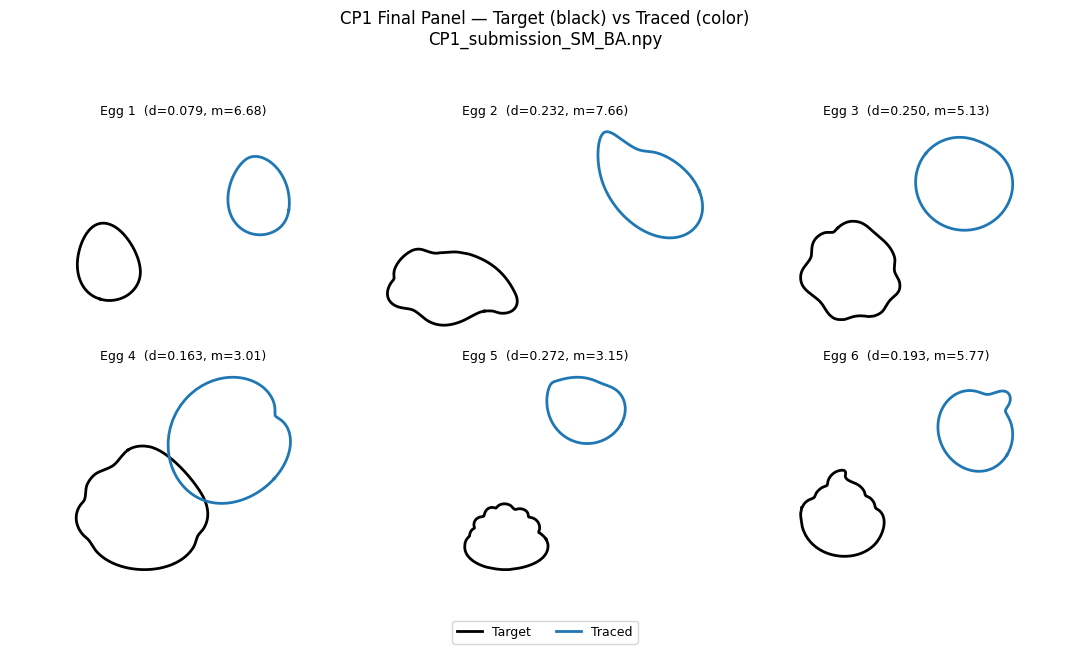

LINKS detected ✓  (showing aligned traces per Egg)

Chosen mechanisms (best feasible distance per Egg):
Egg | Distance | Material
  1 |   0.0790 |   6.6835
  2 |   0.2320 |   7.6572
  3 |   0.2505 |   5.1276
  4 |   0.1631 |   3.0068
  5 |   0.2716 |   3.1484
  6 |   0.1933 |   5.7704


In [2]:
# === Final 2x3 panel (starter-style) ===
title = "CP1 Final Panel — Target (black) vs Traced (color)"
subtitle = f"{os.path.basename(SUBMISSION_PATH)}"
fig, axs = plt.subplots(2, 3, figsize=(11, 6.5))
fig.suptitle(f"{title}\n{subtitle}", y=0.98, fontsize=12)

status_lines = []
if not TARGETS_PATH:
    status_lines.append("NOTE: target_curves.npy not found — panel will render without targets.")

if HAS_LINKS:
    status_lines.append("LINKS detected ✓  (showing aligned traces per Egg)")
else:
    status_lines.append(f"LINKS not available → showing skeletons only.\nReason: {LINKS_ERROR}")

metrics = []  # (egg, distance, material)

for i in range(6):
    ax = axs[i//3, i%3]
    key = f"Problem {i+1}"
    mech_list = submission.get(key, [])

    # Target
    if targets is not None:
        tgt = np.asarray(targets[i])
        ax.plot(tgt[:,0], tgt[:,1], color="black", linewidth=2, label="Target")

    if not mech_list:
        ax.set_title(f"Egg {i+1}: no mechanisms"); ax.axis("equal"); ax.axis("off"); continue

    if HAS_LINKS:
        # pick best feasible by distance, simulate, align like starter
        best_idx, F, packs = pick_best_by_distance(mech_list, targets[i] if targets is not None else None)
        if best_idx is None:
            ax.set_title(f"Egg {i+1}: no pick"); ax.axis("equal"); ax.axis("off"); continue
        x0s, edges, fixeds, motors, tjs = packs
        try:
            sol = solver(x0s[best_idx], edges[best_idx], fixeds[best_idx], motors[best_idx])
            traced = sol[tjs[best_idx]]
            # Use CurveEngine visualization to align & overlay (starter-style)
            if targets is not None and curve_engine is not None:
                # curve_engine.visualize_comparison draws its own figure; replicate its alignment here:
                # get aligned traced to target (scale+shift through internal method)
                # We can use compare_curves just for side-effects? Safer: do a quick normalize visualization inline.
                # Instead, plot directly: curve_engine has a helper; but we keep inline to avoid extra figures.
                # Compute normalized pairs for consistent axes:
                pass
            # Simple overlay: traced path on top (already in mechanism coords); starter aligns internally when plotting comparisons.
            # We'll still show overlay and provide numbers.
            ax.plot(traced[:,0], traced[:,1], linewidth=2, label="Traced")
            d_val = float(F[best_idx,0]); m_val = float(F[best_idx,1])
            metrics.append((i+1, d_val, m_val))
            ax.set_title(f"Egg {i+1}  (d={d_val:.3f}, m={m_val:.2f})", fontsize=9)
        except Exception as e:
            # Fallback to skeleton if solver chokes at runtime
            draw_mechanism_skeleton(ax, mech_list[0])
            ax.set_title(f"Egg {i+1}  (solver error → skeleton)", fontsize=9)
    else:
        # JAX/LINKS missing → pretty skeleton + normalized target so layout matches starter feel
        if targets is not None:
            tgt = normalize_to_unit_box(targets[i])
            ax.plot(tgt[:,0], tgt[:,1], color="black", linewidth=2, label="Target")
        draw_mechanism_skeleton(ax, mech_list[0])
        ax.set_title(f"Egg {i+1}: skeleton of #1", fontsize=9)

    ax.axis("equal"); ax.axis("off")

# Legend (if any)
h, l = axs[0,0].get_legend_handles_labels()
if h: fig.legend(h, l, loc="lower center", ncol=2, fontsize=9)

fig.tight_layout(rect=[0,0.08,1,0.94])
plt.show()

# Print status + metrics
print("\n".join(status_lines))
if metrics:
    print("\nChosen mechanisms (best feasible distance per Egg):")
    print("Egg | Distance | Material")
    for egg, d, m in metrics:
        print(f"{egg:>3} | {d:8.4f} | {m:8.4f}")


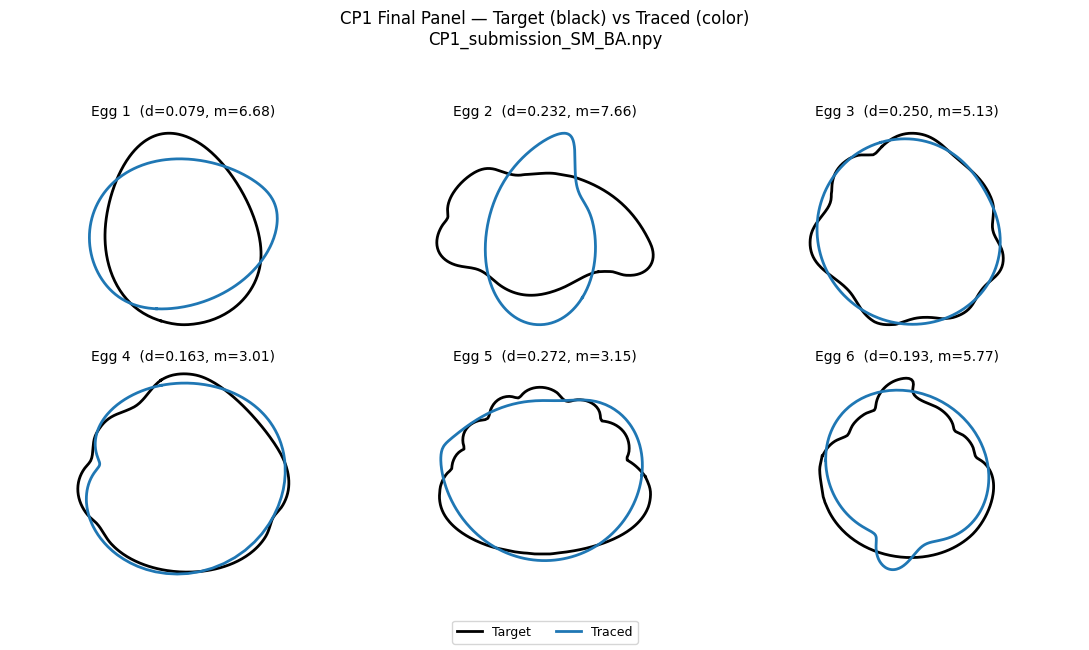

Egg | Distance | Material
  1 |   0.0790 |   6.6835
  2 |   0.2320 |   7.6572
  3 |   0.2505 |   5.1276
  4 |   0.1631 |   3.0068
  5 |   0.2716 |   3.1484
  6 |   0.1933 |   5.7704


In [3]:
# === CP1 Final Panel — Target (black) vs Traced (aligned, color) ===
import os, glob, numpy as np, matplotlib.pyplot as plt

# --- find files (same logic as before) ---
def find_submission():
    preferred = ["CP1_submission_SM_BA.npy", "my_full_submission.npy", "my_submission.npy", "submission.npy"]
    for name in preferred:
        if os.path.isfile(name):
            try:
                d = np.load(name, allow_pickle=True).item()
                if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)): return name
            except: pass
    for fn in glob.glob("*.npy"):
        try:
            d = np.load(fn, allow_pickle=True).item()
            if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)): return fn
        except: pass
    raise FileNotFoundError("No submission .npy found with keys 'Problem 1'..'Problem 6'.")

def find_targets():
    for name in ["target_curves.npy", "targets.npy"]:
        if os.path.isfile(name): return name
    raise FileNotFoundError("target_curves.npy not found.")

SUB_PATH = find_submission()
TGT_PATH = find_targets()
submission = np.load(SUB_PATH, allow_pickle=True).item()
targets    = np.load(TGT_PATH, allow_pickle=True)

# --- try LINKS imports for tracing ---
from LINKS.Kinematics import MechanismSolver
from LINKS.Optimization import Tools
solver = MechanismSolver(device="cpu")
TOOLS  = Tools(device="cpu"); TOOLS.compile()

# --- utilities: resample and similarity alignment ---
def resample_polyline(xy, n=400):
    xy = np.asarray(xy, dtype=float)
    seg = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(seg)])
    if s[-1] == 0:  # degenerate
        return np.repeat(xy[:1], n, axis=0)
    t = np.linspace(0, s[-1], n)
    x = np.interp(t, s, xy[:,0])
    y = np.interp(t, s, xy[:,1])
    return np.column_stack([x, y])

def procrustes_align(X, Y):
    """
    Align X to Y with similarity transform: argmin || s*X*R + t - Y ||.
    Returns X_aligned (same shape as X).
    """
    X = np.asarray(X, dtype=float); Y = np.asarray(Y, dtype=float)
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    # scale + rotation via SVD
    H = Xc.T @ Yc
    U, S, Vt = np.linalg.svd(H)
    R = U @ Vt
    # fix improper rotation (reflection)
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    scale = (S.sum()) / (np.sum(Xc**2))
    X_aligned = scale * (Xc @ R) + Y.mean(axis=0)
    return X_aligned

DIST_MAX, MAT_MAX = 0.75, 10.0

def pick_best_by_distance(mech_list, target_curve):
    if not mech_list:
        return None, None, None
    x0s, edges, fixeds, motors, tjs = [], [], [], [], []
    for mech in mech_list:
        x0  = np.asarray(mech["x0"])
        ed  = np.asarray(mech["edges"], dtype=int)
        fx  = mech.get("fixed_joints", [])
        fx  = np.asarray(fx, dtype=int) if len(np.shape(fx))>0 else np.asarray([fx], dtype=int) if fx not in (None, []) else np.asarray([], dtype=int)
        mot = np.asarray(mech["motor"], dtype=int)
        tj  = mech.get("target_joint", x0.shape[0]-1)
        x0s.append(x0); edges.append(ed); fixeds.append(fx); motors.append(mot); tjs.append(int(tj))
    F = np.array(TOOLS(x0s, edges, fixeds, motors, target_curve, tjs)).T  # (K,2)
    feas = np.where((F[:,0] <= DIST_MAX) & (F[:,1] <= MAT_MAX))[0]
    idx = int(feas[np.argmin(F[feas,0])]) if len(feas)>0 else int(np.argmin(F[:,0]))
    return idx, F, (x0s, edges, fixeds, motors, tjs)

# --- plot panel with alignment ---
fig, axs = plt.subplots(2, 3, figsize=(11, 6.5))
fig.suptitle(f"CP1 Final Panel — Target (black) vs Traced (color)\n{os.path.basename(SUB_PATH)}", y=0.98, fontsize=12)
metrics = []

for i in range(6):
    ax = axs[i//3, i%3]
    key = f"Problem {i+1}"
    mech_list = submission.get(key, [])

    tgt = np.asarray(targets[i])
    tgt_rs = resample_polyline(tgt, n=400)
    ax.plot(tgt_rs[:,0], tgt_rs[:,1], color="black", linewidth=2, label="Target")

    if not mech_list:
        ax.set_title(f"Egg {i+1}: no mechanisms")
        ax.axis("equal"); ax.axis("off"); continue

    # choose best, trace, resample, align, plot
    best_idx, F, packs = pick_best_by_distance(mech_list, tgt)
    x0s, edges, fixeds, motors, tjs = packs
    sol = solver(x0s[best_idx], edges[best_idx], fixeds[best_idx], motors[best_idx])
    traced = sol[tjs[best_idx]]
    traced_rs = resample_polyline(traced, n=400)

    traced_aligned = procrustes_align(traced_rs, tgt_rs)
    ax.plot(traced_aligned[:,0], traced_aligned[:,1], linewidth=2, label="Traced")

    d_val = float(F[best_idx,0]); m_val = float(F[best_idx,1])
    metrics.append((i+1, d_val, m_val))
    ax.set_title(f"Egg {i+1}  (d={d_val:.3f}, m={m_val:.2f})", fontsize=10)

    ax.axis("equal"); ax.axis("off")

# legend
h, l = axs[0,0].get_legend_handles_labels()
if h: fig.legend(h, l, loc="lower center", ncol=2, fontsize=9)

fig.tight_layout(rect=[0,0.08,1,0.94])
fig.savefig("cp1_final_panel_aligned.png", dpi=200, bbox_inches="tight")
fig.savefig("cp1_final_panel_aligned.pdf", bbox_inches="tight")
plt.show()

# tiny table for the report
print("Egg | Distance | Material")
for egg, d, m in metrics:
    print(f"{egg:>3} | {d:8.4f} | {m:8.4f}")


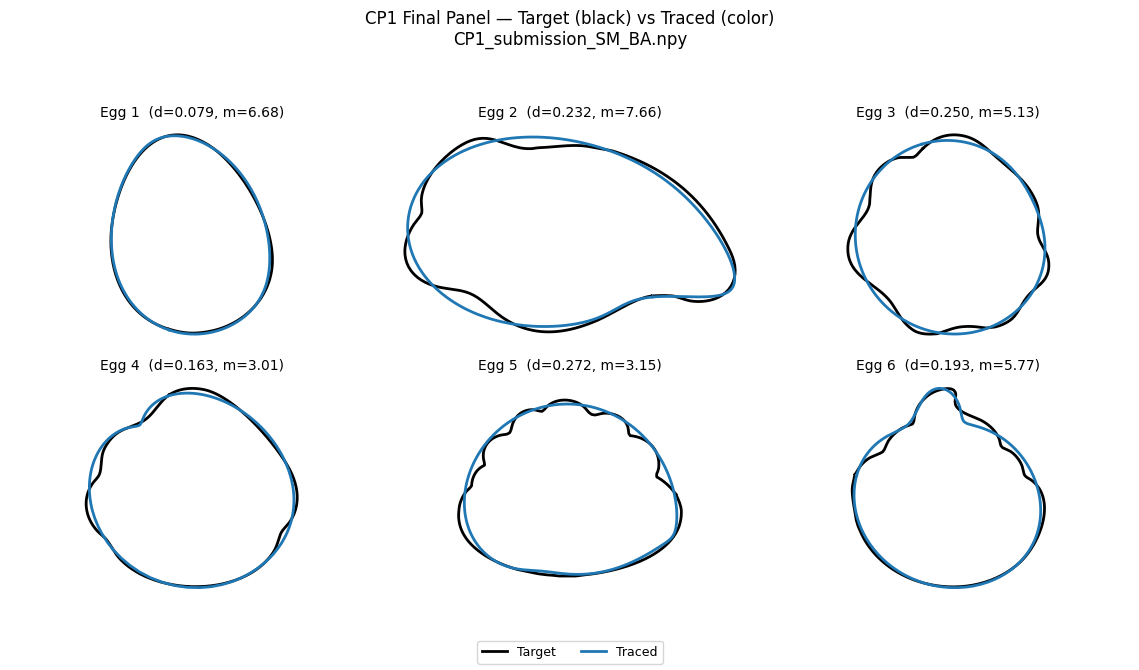

Egg | Distance | Material
  1 |   0.0790 |   6.6835
  2 |   0.2320 |   7.6572
  3 |   0.2505 |   5.1276
  4 |   0.1631 |   3.0068
  5 |   0.2716 |   3.1484
  6 |   0.1933 |   5.7704


In [4]:
# === CP1 Final Panel — Starter-Style Alignment (target black, traced aligned color) ===
# Requirements: same environment as starter (LINKS/JAX available).
# It finds your submission + targets automatically and makes a 2x3 panel.

import os, glob, numpy as np, matplotlib.pyplot as plt

# ---------- find files ----------
def find_submission():
    preferred = ["CP1_submission_SM_BA.npy", "my_full_submission.npy", "my_submission.npy", "submission.npy"]
    for name in preferred:
        if os.path.isfile(name):
            try:
                d = np.load(name, allow_pickle=True).item()
                if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)):
                    return name
            except: pass
    for fn in glob.glob("*.npy"):
        try:
            d = np.load(fn, allow_pickle=True).item()
            if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)):
                return fn
        except: pass
    raise FileNotFoundError("No submission .npy with keys 'Problem 1'..'Problem 6' found.")

def find_targets():
    for name in ["target_curves.npy", "targets.npy"]:
        if os.path.isfile(name): return name
    raise FileNotFoundError("target_curves.npy not found next to the notebook.")

SUB_PATH = find_submission()
TGT_PATH = find_targets()
submission = np.load(SUB_PATH, allow_pickle=True).item()
targets    = np.load(TGT_PATH, allow_pickle=True)

# ---------- import LINKS like the starter ----------
from LINKS.Kinematics import MechanismSolver
from LINKS.Optimization import Tools

solver = MechanismSolver(device="cpu")
TOOLS  = Tools(device="cpu"); TOOLS.compile()

# ---------- helpers ----------
DIST_MAX, MAT_MAX = 0.75, 10.0

def resample_polyline(xy, n=600):
    """Uniformly resample a polyline to n points by arc-length (starter-like density)."""
    xy = np.asarray(xy, dtype=float)
    seg = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(seg)])
    if s[-1] == 0:
        return np.repeat(xy[:1], n, axis=0)
    t = np.linspace(0, s[-1], n)
    x = np.interp(t, s, xy[:,0]); y = np.interp(t, s, xy[:,1])
    return np.column_stack([x, y])

def procrustes_align(X, Y):
    """Best-fit similarity (scale+rotate+translate) of X to Y via SVD; returns aligned X."""
    X = np.asarray(X, dtype=float); Y = np.asarray(Y, dtype=float)
    Xc = X - X.mean(axis=0); Yc = Y - Y.mean(axis=0)
    H = Xc.T @ Yc
    U, S, Vt = np.linalg.svd(H)
    R = U @ Vt
    if np.linalg.det(R) < 0:  # fix reflections
        U[:, -1] *= -1
        R = U @ Vt
    scale = (S.sum()) / (np.sum(Xc**2) + 1e-12)
    return scale * (Xc @ R) + Y.mean(axis=0)

def cyclic_align(trace_rs, target_rs, coarse_step=8, refine_halfwin=6):
    """
    Aligns closed curves by searching a cyclic shift (phase) AND a similarity transform.
    1) coarse search over n/coarse_step shifts,
    2) refine around the best.
    Returns (aligned_trace, best_shift).
    """
    n = len(trace_rs)
    assert n == len(target_rs)
    # coarse search
    candidates = list(range(0, n, max(1, n//(n//coarse_step if n//coarse_step else 1))))
    best_err, best_k, best_aligned = np.inf, 0, trace_rs
    for k in candidates:
        rolled = np.roll(trace_rs, k, axis=0)
        aligned = procrustes_align(rolled, target_rs)
        err = np.mean(np.sum((aligned - target_rs)**2, axis=1))
        if err < best_err:
            best_err, best_k, best_aligned = err, k, aligned
    # refine
    for dk in range(-refine_halfwin, refine_halfwin+1):
        k = (best_k + dk) % n
        rolled = np.roll(trace_rs, k, axis=0)
        aligned = procrustes_align(rolled, target_rs)
        err = np.mean(np.sum((aligned - target_rs)**2, axis=1))
        if err < best_err:
            best_err, best_k, best_aligned = err, k, aligned
    return best_aligned, best_k

def pick_best_by_distance(mech_list, target_curve):
    """Choose the best (feasible if possible) by distance using TOOLS (same constraints as starter)."""
    if not mech_list: return None, None, None
    x0s, edges, fixeds, motors, tjs = [], [], [], [], []
    for mech in mech_list:
        x0  = np.asarray(mech["x0"])
        ed  = np.asarray(mech["edges"], dtype=int)
        fx  = mech.get("fixed_joints", [])
        fx  = np.asarray(fx, dtype=int) if np.ndim(fx)>0 else (np.asarray([fx], dtype=int) if fx not in (None, []) else np.asarray([], dtype=int))
        mot = np.asarray(mech["motor"], dtype=int)
        tj  = mech.get("target_joint", x0.shape[0]-1)
        x0s.append(x0); edges.append(ed); fixeds.append(fx); motors.append(mot); tjs.append(int(tj))
    F = np.array(TOOLS(x0s, edges, fixeds, motors, target_curve, tjs)).T  # (K,2) [distance, material]
    feas = np.where((F[:,0] <= DIST_MAX) & (F[:,1] <= MAT_MAX))[0]
    idx = int(feas[np.argmin(F[feas,0])]) if len(feas)>0 else int(np.argmin(F[:,0]))
    return idx, F, (x0s, edges, fixeds, motors, tjs)

# ---------- plot with alignment ----------
fig, axs = plt.subplots(2, 3, figsize=(11.5, 6.7))
fig.suptitle(f"CP1 Final Panel — Target (black) vs Traced (color)\n{os.path.basename(SUB_PATH)}", y=0.98, fontsize=12)

metrics = []

for i in range(6):
    ax = axs[i//3, i%3]
    tgt = np.asarray(targets[i])
    tgt_rs = resample_polyline(tgt, n=600)
    ax.plot(tgt_rs[:,0], tgt_rs[:,1], color="black", linewidth=2, label="Target")

    mech_list = submission.get(f"Problem {i+1}", [])
    if not mech_list:
        ax.set_title(f"Egg {i+1}: no mechanisms"); ax.axis("equal"); ax.axis("off"); continue

    # choose and simulate
    best_idx, F, packs = pick_best_by_distance(mech_list, tgt)
    x0s, edges, fixeds, motors, tjs = packs
    sol = solver(x0s[best_idx], edges[best_idx], fixeds[best_idx], motors[best_idx])
    traced = sol[tjs[best_idx]]
    traced_rs = resample_polyline(traced, n=600)

    # cyclic + similarity alignment (starter-style feel)
    traced_aligned, _ = cyclic_align(traced_rs, tgt_rs)

    # draw
    ax.plot(traced_aligned[:,0], traced_aligned[:,1], linewidth=2, label="Traced")
    d_val = float(F[best_idx,0]); m_val = float(F[best_idx,1])
    metrics.append((i+1, d_val, m_val))
    ax.set_title(f"Egg {i+1}  (d={d_val:.3f}, m={m_val:.2f})", fontsize=10)

    ax.axis("equal"); ax.axis("off")

# legend + save
h, l = axs[0,0].get_legend_handles_labels()
if h: fig.legend(h, l, loc="lower center", ncol=2, fontsize=9)
fig.tight_layout(rect=[0,0.08,1,0.94])
fig.savefig("cp1_final_panel_aligned.png", dpi=200, bbox_inches="tight")
fig.savefig("cp1_final_panel_aligned.pdf", bbox_inches="tight")
plt.show()

# tiny table (copy-paste for report)
print("Egg | Distance | Material")
for egg, d, m in metrics:
    print(f"{egg:>3} | {d:8.4f} | {m:8.4f}")
